Imports

Summary:

- removed dropouts as we have a high bias problem not a high varience one
- made the modelmore dense and tested with 5 layers and 7 layers.
- Sweet spot at 5 layers, got an increase in accuracy


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import requests
import time
import os
import copy
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from PIL import Image
# from torch.optim import lr_scheduler
# from torchvision import datasets, models, transforms


Display the matplotlib images inline, and set to interactive mode

In [ ]:
%matplotlib inline

plt.ion()

First, load the dataset and print some of the images just to test the loader correctly.

In [ ]:
img_32x32_size_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),  # ensure that images are 32x32
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalize to [-1,1]
])

gtsrb_path = "/content"

train_percent = 0.8 # 80% training set -> 20% validation set

train_set = torchvision.datasets.GTSRB(root=gtsrb_path, split='train', download=True, transform=img_32x32_size_transform)

train_size = int(train_percent*len(train_set))

val_size = int(len(train_set) - train_size)

train_set, val_set = random_split(train_set,[train_size, val_size])

test_set = torchvision.datasets.GTSRB(root=gtsrb_path, split='test', download=True, transform=img_32x32_size_transform)

test_set_size = int(len(test_set)*0.9)

test_vis_size= int(len(test_set) - test_set_size)

test_set, test_vis_set = random_split(test_set,[test_set_size,test_vis_size])

training_path = f"{gtsrb_path}/gtsrb/GTSRB/Training"

100%|██████████| 187M/187M [00:06<00:00, 28.6MB/s]


Extracting /content/gtsrb/GTSRB-Training_fixed.zip to /content/gtsrb


100%|██████████| 89.0M/89.0M [00:03<00:00, 24.9MB/s]


Extracting /content/gtsrb/GTSRB_Final_Test_Images.zip to /content/gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 299kB/s]


Extracting /content/gtsrb/GTSRB_Final_Test_GT.zip to /content/gtsrb


Setting the hyper parameters

In [ ]:
bs = 128  # batch size
lr = 0.01  # learning rate
epochs = 20  # number of epochs
momentum = 0.9 # for optimizer
step_size = 7 # step size for
gamma = 0.1 # gamma for learning rate scheduler

Initializing the classes label names

In [ ]:
# TODO: create the label names array to map the numbers into label names for presenting predictions

class_names = [
    "Speed limit (20km/h)",         # 0
    "Speed limit (30km/h)",         # 1
    "Speed limit (50km/h)",         # 2
    "Speed limit (60km/h)",         # 3
    "Speed limit (70km/h)",         # 4
    "Speed limit (80km/h)",         # 5
    "End of speed limit (80km/h)",  # 6
    "Speed limit (100km/h)",        # 7
    "Speed limit (120km/h)",        # 8
    "No passing",                   # 9
    "No passing for vehicles over 3.5 metric tons",  # 10
    "Right-of-way at the next intersection",         # 11
    "Priority road",                # 12
    "Yield",                        # 13
    "Stop",                         # 14
    "No vehicles",                  # 15
    "Vehicles over 3.5 metric tons prohibited",      # 16
    "No entry",                     # 17
    "General caution",              # 18
    "Dangerous curve to the left",  # 19
    "Dangerous curve to the right", # 20
    "Double curve",                 # 21
    "Bumpy road",                   # 22
    "Slippery road",                # 23
    "Road narrows on the right",    # 24
    "Road work",                    # 25
    "Traffic signals",              # 26
    "Pedestrians",                  # 27
    "Children crossing",            # 28
    "Bicycles crossing",            # 29
    "Beware of ice/snow",           # 30
    "Wild animals crossing",        # 31
    "End of all speed and passing limits",  # 32
    "Turn right ahead",             # 33
    "Turn left ahead",              # 34
    "Ahead only",                   # 35
    "Go straight or right",         # 36
    "Go straight or left",          # 37
    "Keep right",                   # 38
    "Keep left",                    # 39
    "Roundabout mandatory",         # 40
    "End of no passing",            # 41
    "End of no passing by vehicles over 3.5 metric tons"  # 42
]

Creating the loader for the data

In [ ]:
train_data_loader = DataLoader(train_set,batch_size=bs, shuffle=True) # schuffle only in train set
val_data_loader = DataLoader(val_set,batch_size=bs, shuffle=True)
test_data_loader = DataLoader(test_set,batch_size=bs, shuffle=False)
test_vis_data_loader = DataLoader(test_vis_set, batch_size=bs, shuffle=False)

data_loaders = {
    "train": train_data_loader,
    "val" : val_data_loader,
    "test": test_data_loader,
    "vis": test_vis_data_loader
}

data_set_sizes = {
    "train": len(train_data_loader),
    "val": len(val_data_loader),
    "test": len(test_data_loader),
    "vis": len(test_vis_data_loader)
}

Optionally print some images out of the dataset (since batch size is 64, we get 64 images out of the dataset)

Setting up the model

In [ ]:
# Load the pre-trained MobileNetV2 model
# pretrained=True indicates we'll use weights pre-trained on ImageNet
model = torchvision.models.mobilenet_v2(pretrained=True)

# Get the number of input features for the classifier's fully connected layer
# This is needed to define the input size for our custom classifier
in_feature_number = model.classifier[1].in_features

# Replace the original classifier with a custom one
# This allows us to fine-tune the model for our specific task (GTSRB dataset)
# model.classifier = nn.Sequential(
#     #nn.Dropout(p=0.2,inplace=False),  # Add dropout for regularization
#     nn.Linear(in_feature_number, 43) # Fully connected layer with 43 outputs (for 43 classes)
# )

model.classifier = nn.Sequential(
    nn.Linear(in_feature_number, 2048),  # First dense layer with 2048 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(2048, 1024),                # Second dense layer with 1024 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(1024, 512),                 # Third dense layer with 512 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(512, 256),                  # Fourth dense layer with 256 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(256, 43)                    # Final output layer with 43 classes (for GTSRB)
)



# Print the model's architecture to the console
#print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 86.3MB/s]


Using the GPU if available

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Setting up the training method

In [ ]:
# Generic function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Copy weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store metrics for plotting
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / data_set_sizes[phase]
            epoch_acc = running_corrects.double().cpu().numpy() / data_set_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Record loss and accuracy for plotting
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

        # Plot loss and accuracy
    epochs_range = range(num_epochs)
    plt.figure(figsize=(12, 4))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss_history, label="Training Loss")
    plt.plot(epochs_range, val_loss_history, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc_history, label="Training Accuracy")
    plt.plot(epochs_range, val_acc_history, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.show()


    return model

Setting up the visualizing method

In [ ]:
def evaluate_model(model):
    was_training = model.training
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        model.train(mode=was_training)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    return conf_matrix

Method to show some predictions on unseen images

In [ ]:
def show_predictions(model, num_of_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))

    # with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['vis']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            inp_size = inputs.size()[1]

            for j in range(inp_size):
                images_so_far += 1
                ax = plt.subplot(inp_size, num_of_images//inp_size, images_so_far)
                ax.axis('off')
                ax.set_title(f"pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}")

                resized_image = torchvision.transforms.ToTensor()(torchvision.transforms.Resize((1024, 1024))(torchvision.transforms.ToPILImage()(inputs.cpu().data[j])))

                ax.imshow(resized_image.permute(1, 2, 0))

                if images_so_far == num_of_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

IndentationError: unexpected indent (<ipython-input-20-6fe40a31c119>, line 8)

Preparing the model for feature extraction (original model's weights are freezed, classfier layer is trainable), setting the loss function, optimizer and learning rate scheduler

In [ ]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.classifier.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
loss_function = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Train the model

Epoch 0/19
--------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 449.5951 Acc: 9.6168
val Loss: 412.5135 Acc: 16.0952

Epoch 1/19
--------------------
train Loss: 357.3969 Acc: 27.7545
val Loss: 305.1583 Acc: 37.0952

Epoch 2/19
--------------------
train Loss: 291.7428 Acc: 40.9581
val Loss: 262.0760 Acc: 49.7381

Epoch 3/19
--------------------
train Loss: 251.3671 Acc: 51.8862
val Loss: 225.5338 Acc: 58.4048

Epoch 4/19
--------------------
train Loss: 222.8063 Acc: 58.8683
val Loss: 210.3690 Acc: 62.5476

Epoch 5/19
--------------------
train Loss: 200.3676 Acc: 66.2814
val Loss: 196.3489 Acc: 66.8810

Epoch 6/19
--------------------
train Loss: 164.9461 Acc: 76.8623
val Loss: 167.7689 Acc: 75.7857

Epoch 7/19
--------------------
train Loss: 155.2931 Acc: 79.7365
val Loss: 161.3796 Acc: 77.6667

Epoch 8/19
--------------------
train Loss: 150.6058 Acc: 81.0659
val Loss: 159.9554 Acc: 78.5714

Epoch 9/19
--------------------
train Loss: 147.2434 Acc: 82.4371
val Loss: 156.6950 Acc: 79.0714

Epoch 10/19
--------------------
train Loss

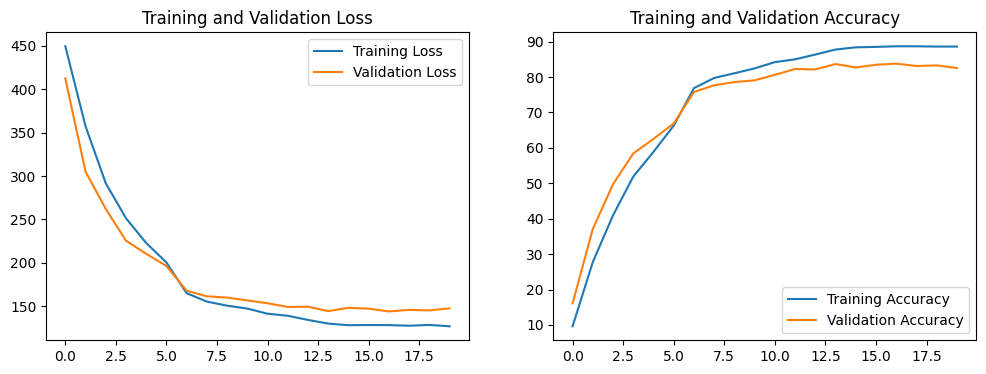

In [ ]:
model = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=epochs)

Evaluate the model form the test data loader

In [ ]:
# conf_matrix = evaluate_model(model)

# plt.figure(figsize=(30,30))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

Show some predictions with the model

In [ ]:
# show_predictions(model) # 6 images are shown by default

Fine tuning model

In [ ]:
for param in model.parameters(): # unfreeze every trainable parameter
    param.requires_grad = True

Train the model again

In [ ]:
model = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=epochs)

Show some predictions with the fine tuned model again

In [ ]:
# conf_matrix = evaluate_model(model)

# plt.figure(figsize=(30,30))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()